In [1]:
import matplotlib.pyplot as plt
from SmoothOT import *
import torch
import torch.nn.functional as tnn
from scipy.optimize import minimize,fmin_l_bfgs_b
use_cuda = 0
torchdeviceId = torch.device('cuda:0') if use_cuda else 'cpu'
torchdtype = torch.float64
from torch.autograd import grad
import numpy as np
import scipy.interpolate
from PIL import Image
import ot
import time 
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [2]:
m=16

x = torch.linspace(-1,1,m)
y = torch.linspace(-1,1,m)
grid = torch.zeros((1,m,m,2)).to(dtype=torchdtype, device=torchdeviceId)
for i in range(0,m):
        for j in range(0,m):
            grid[0,i,j,0]= x[i]
            grid[0,i,j,1]= y[j]

x1 = torch.linspace(-1,1,2*m)
y1 = torch.linspace(-1,1,2*m)
gridup = torch.zeros((1,2*m,2*m,2)).to(dtype=torchdtype, device=torchdeviceId)
for i in range(0,2*m):
        for j in range(0,2*m):
            gridup[0,i,j,0]= x1[i]
            gridup[0,i,j,1]= y1[j]



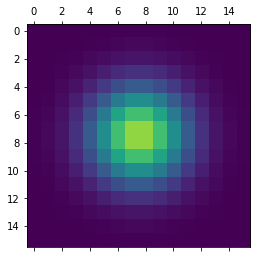

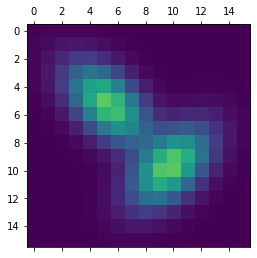

tensor(1.8610, dtype=torch.float64)


In [3]:
a1= 0
b1= 0
G1=torch.Tensor([[5,0],[0,5]]).to(dtype=torchdtype, device=torchdeviceId)

a2= 0
b2= 0
G2=torch.Tensor([[10,10],[0,10]]).to(dtype=torchdtype, device=torchdeviceId)
G3=torch.Tensor([[10,-10],[0,10]]).to(dtype=torchdtype, device=torchdeviceId)

#im = Image.open("A.png")
#im = im.convert("L")
#pix = 255-np.array(im.getdata()).reshape(1,1,im.size[0], im.size[1])
#mu_2=tnn.grid_sample(torch.from_numpy(pix).to(dtype=torchdtype, device=torchdeviceId), grid)
#mu_2=mu_2/mu_2.sum()
#mu_2=mu_2.transpose(2,3)


#im = Image.open("dragonair.jpg")
#im = im.convert("L")
#pix = np.array(im.getdata()).reshape(1,1,im.size[0], im.size[1])
#mu_1=tnn.grid_sample(torch.from_numpy(pix).to(dtype=torchdtype, device=torchdeviceId), grid)
#mu_1=mu_1/mu_1.sum()
#mu_1=mu_1.transpose(2,3)


mu_1 = Gaussian(a1,b1,G1,grid)
mu_2 = Gaussian(a2+.3,b2+.3,G2,grid)+Gaussian(a2-.3,b2-.3,G3,grid)#+Gaussian(a2+.3,b2+.3,G3,grid)
mu_2=mu_2/mu_2.sum()

vmax= 1.2*max(mu_1.max(),mu_2.max()).item()

plt.matshow(mu_1[0,0].cpu().numpy(), vmin=0, vmax=vmax)
plt.show()
plt.matshow(mu_2[0,0].cpu().numpy(), vmin=0, vmax=vmax)
plt.show()

print(L2Error(mu_1,mu_2))

In [4]:
supports = grid.reshape(m*m,1,2)
costmatrix = ((supports-supports.transpose(0,1))**2).sum(dim=2).cpu().numpy()
m1=mu_1[0,0].reshape(m*m).cpu().numpy()
m2=mu_2[0,0].reshape(m*m).cpu().numpy()

Wd =  ot.sinkhorn2(m1, m2, costmatrix, .01)
print(Wd)

0.05671845442483005


In [5]:
params=[]
params+=[{'N':10, 'match_coeff':1000, 'path_coeff':1}]

In [6]:
start =time.time()
vecs = SmoothOT(mu_1,mu_2,grid,params)
print(time.time()-start)
N=vecs.shape[0]

C:\Users\emanh\AppData\Roaming\Python\Python39\site-packages\torch\nn\functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


52.78113508224487


C:\Users\emanh\AppData\Local\Temp\ipykernel_12104\2588000430.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axes[2*i-1].pcolormesh(def_grid[0,:,:,0].cpu(), def_grid[0,:,:,1].cpu(), p[0,0].transpose(0,1).cpu())


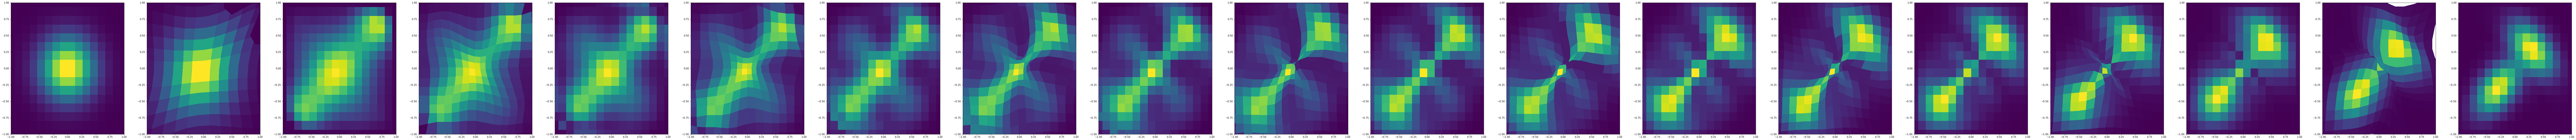

(10, 1, 16, 16)


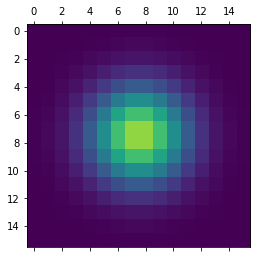

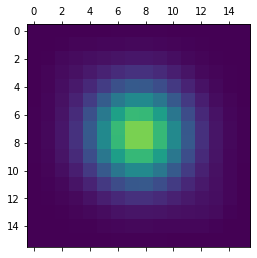

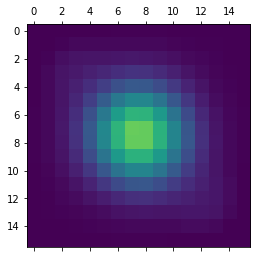

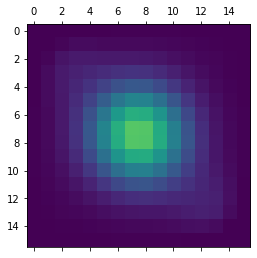

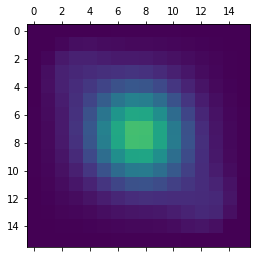

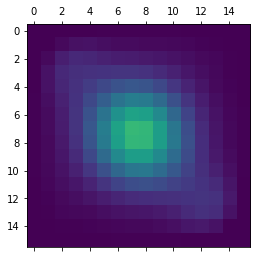

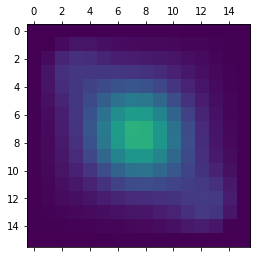

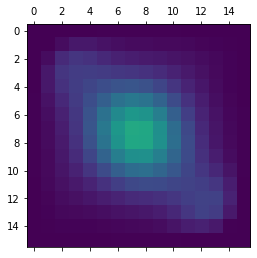

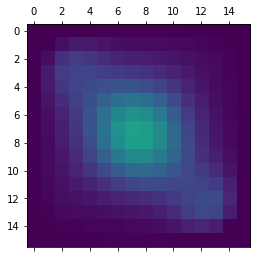

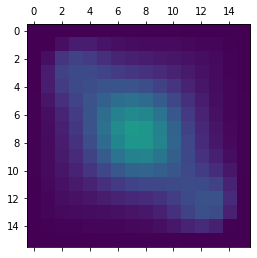

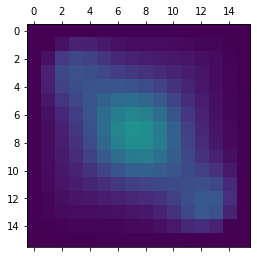

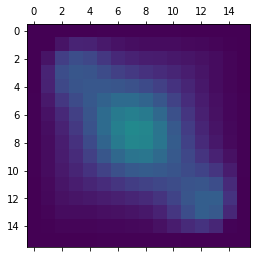

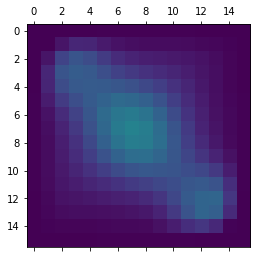

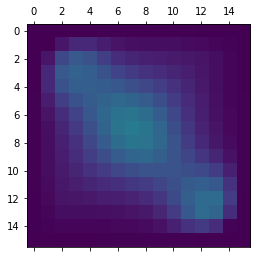

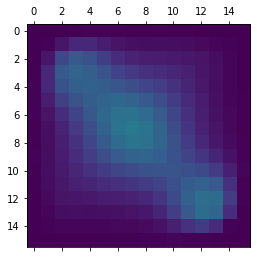

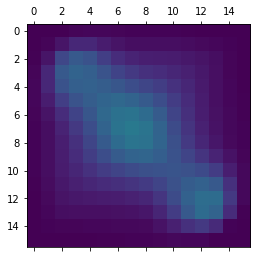

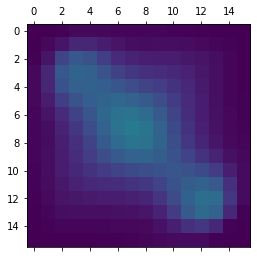

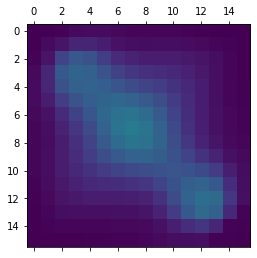

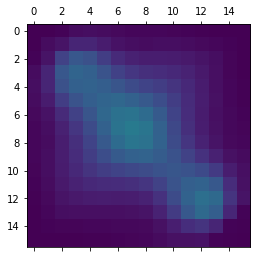

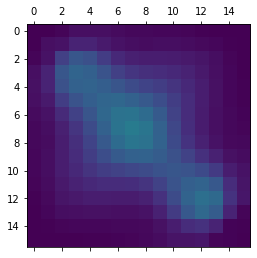

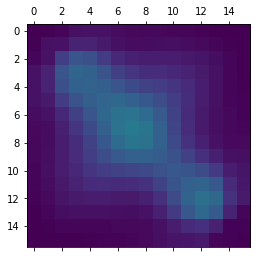

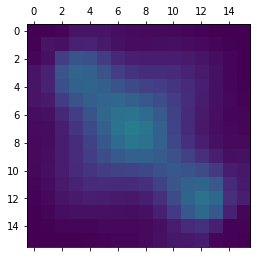

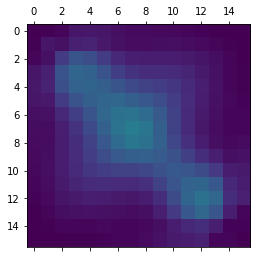

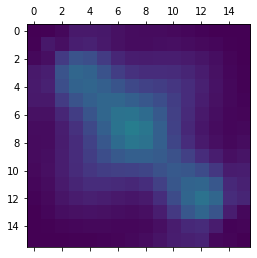

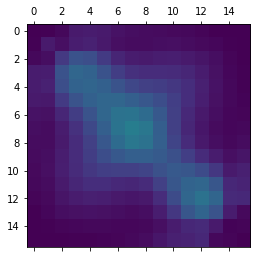

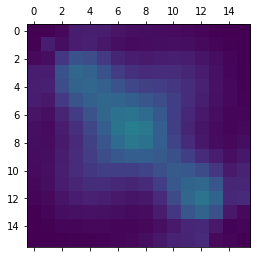

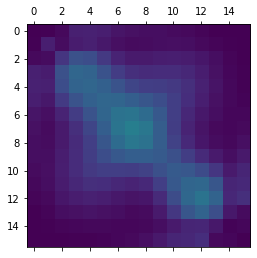

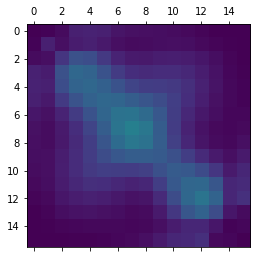

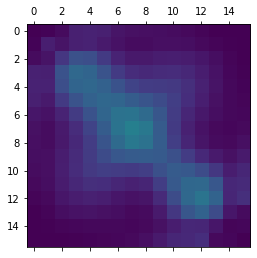

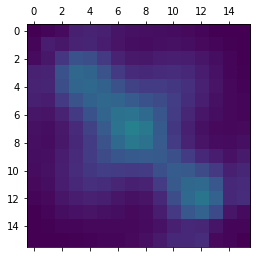

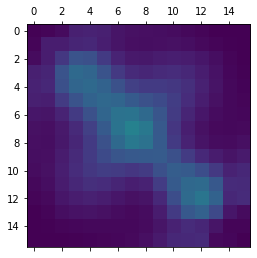

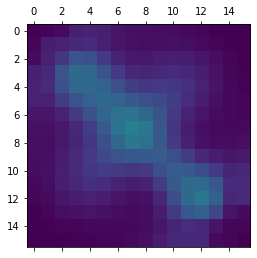

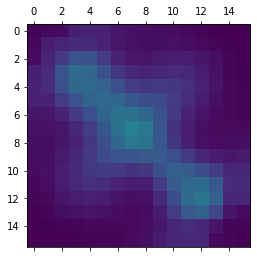

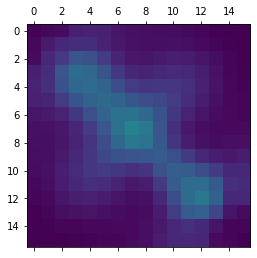

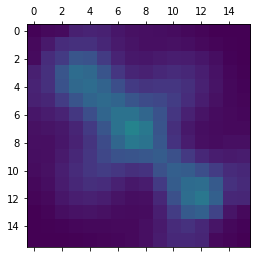

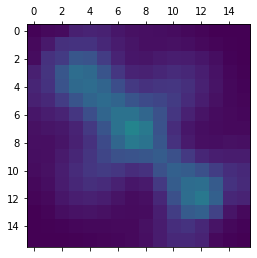

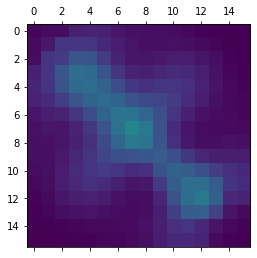

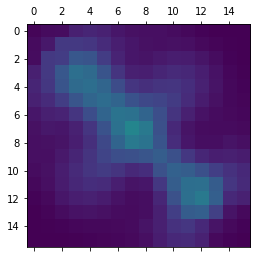

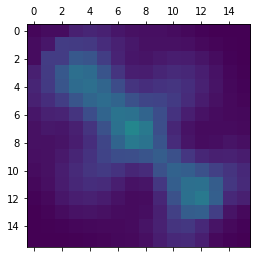

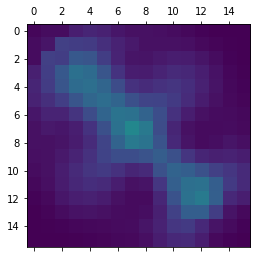

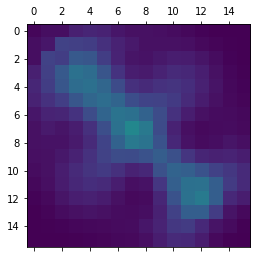

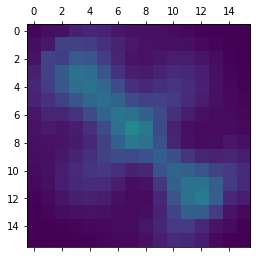

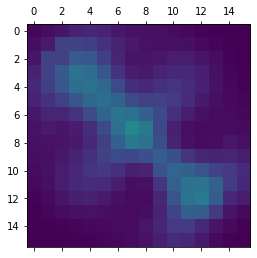

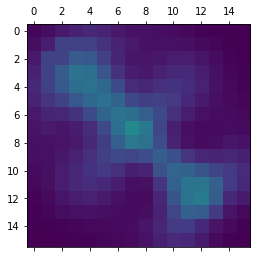

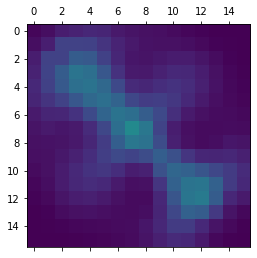

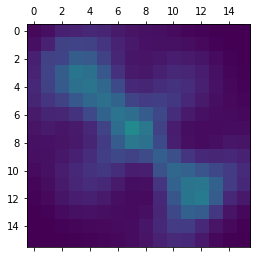

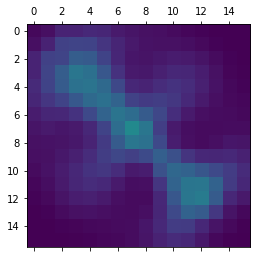

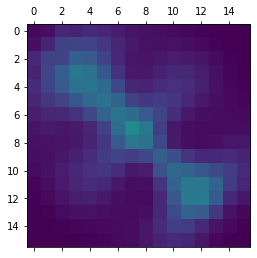

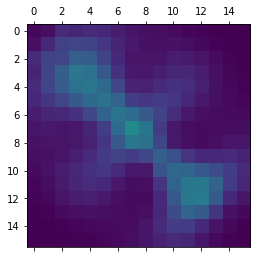

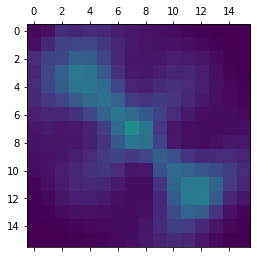

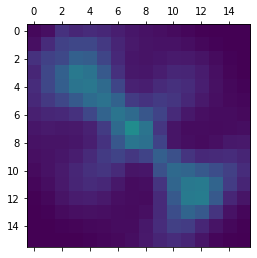

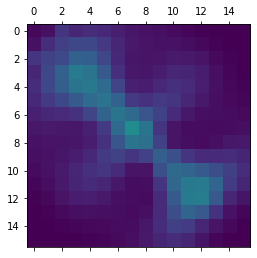

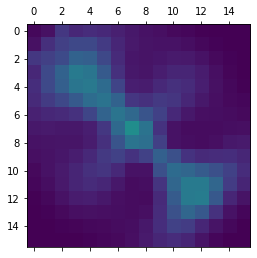

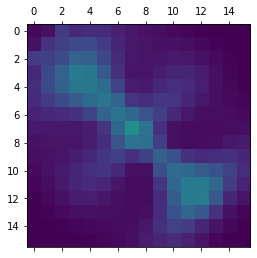

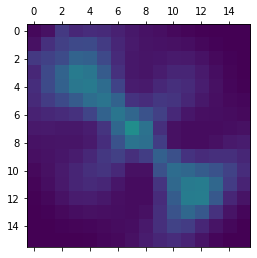

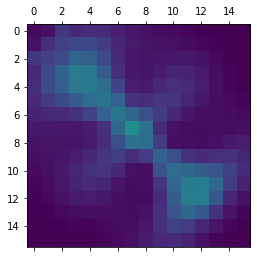

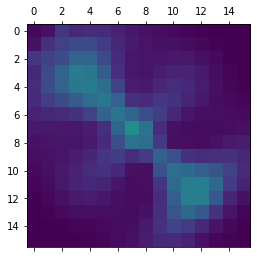

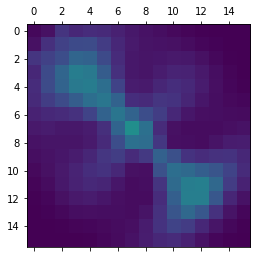

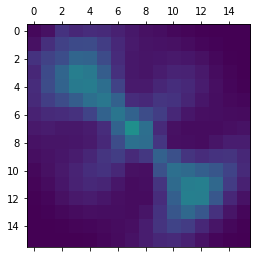

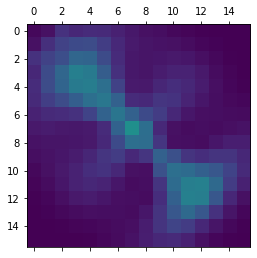

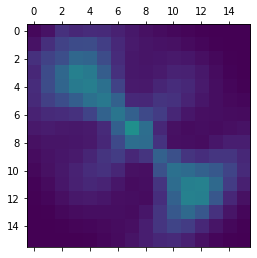

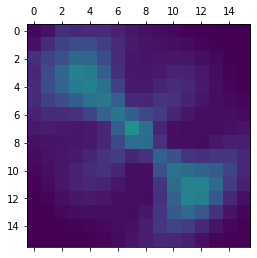

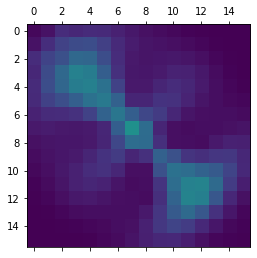

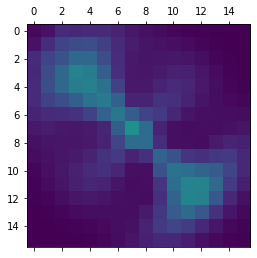

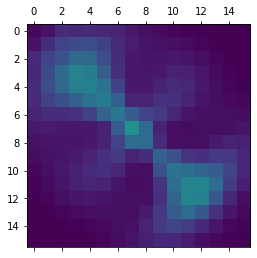

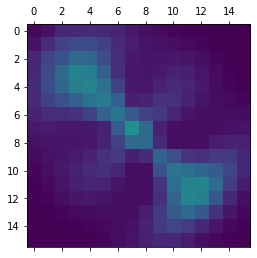

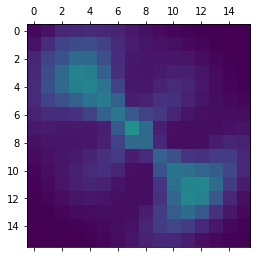

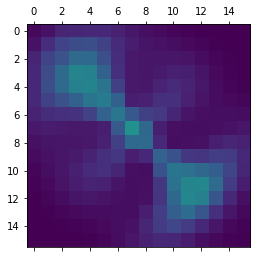

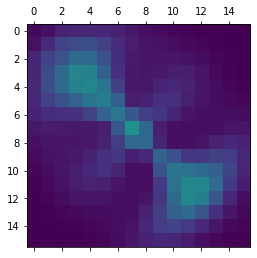

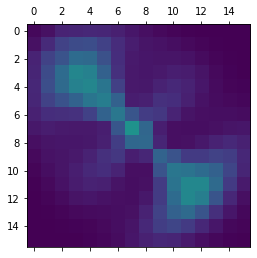

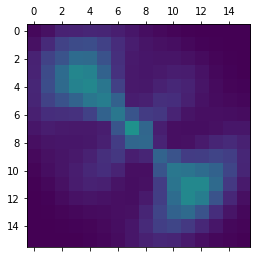

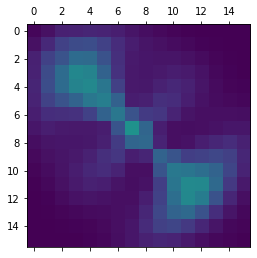

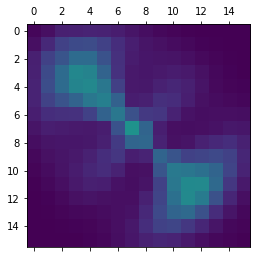

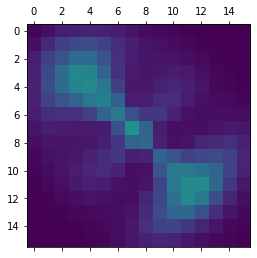

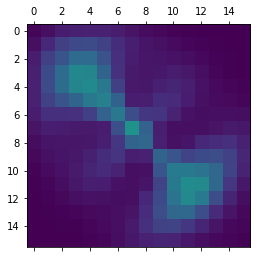

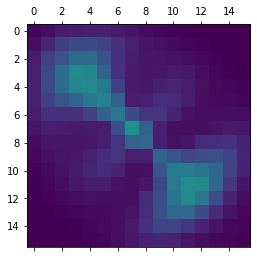

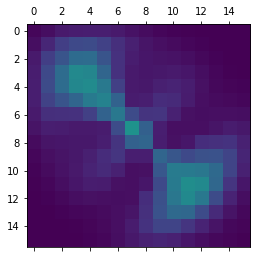

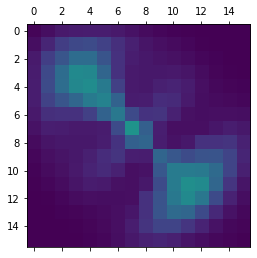

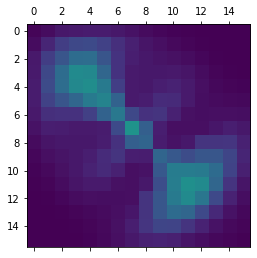

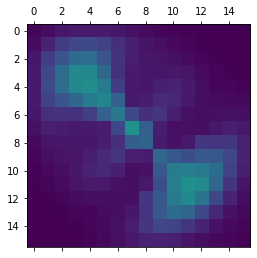

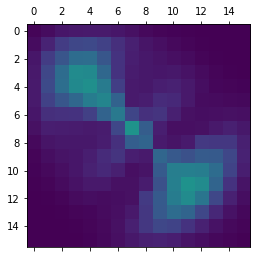

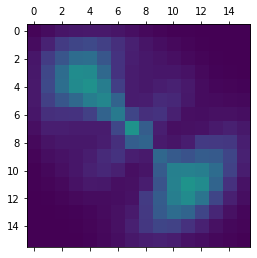

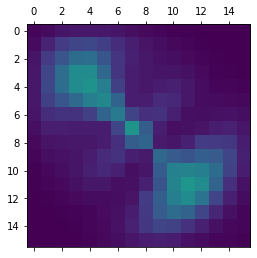

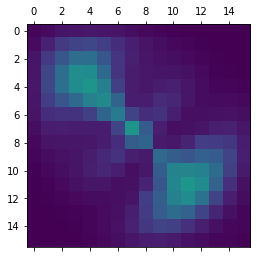

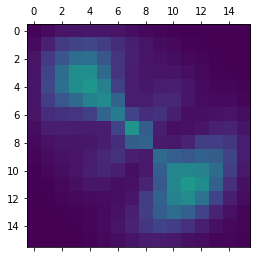

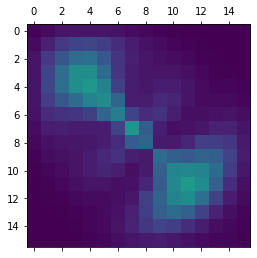

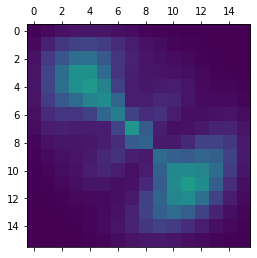

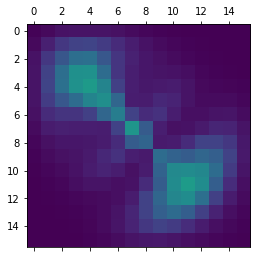

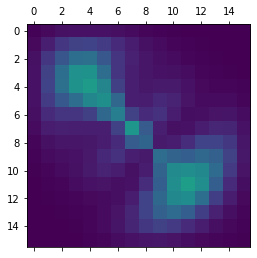

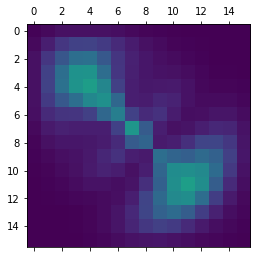

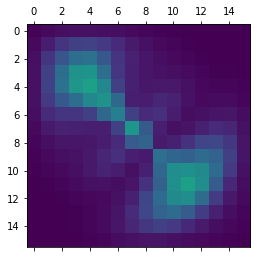

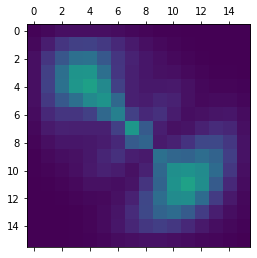

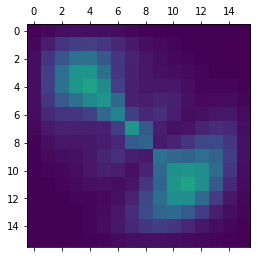

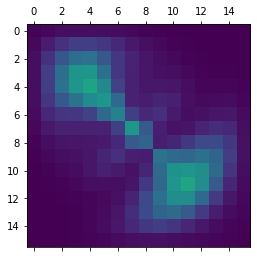

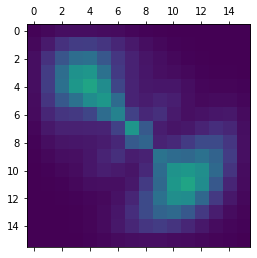

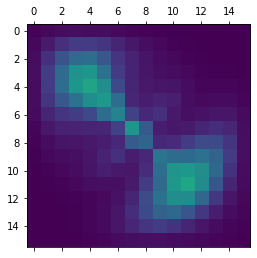

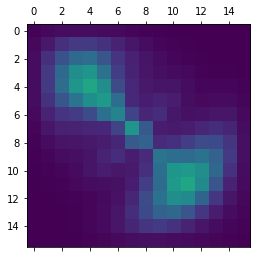

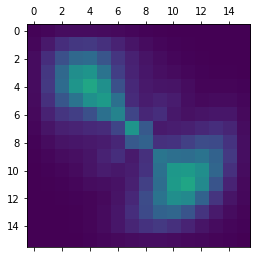

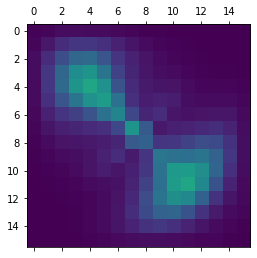

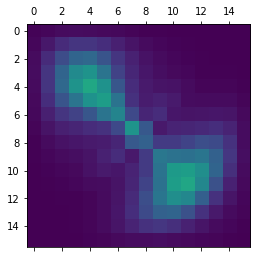

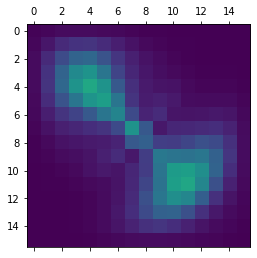

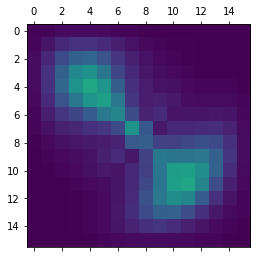

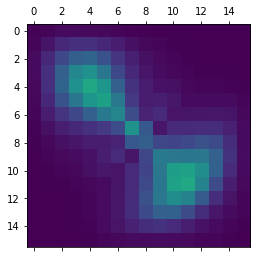

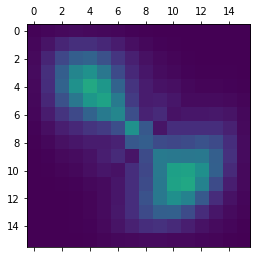

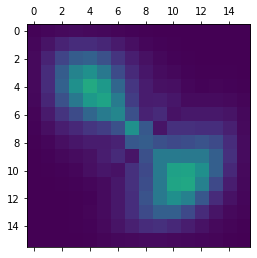

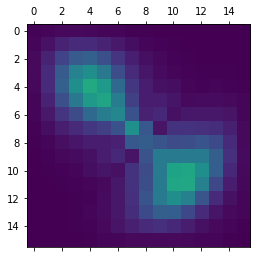

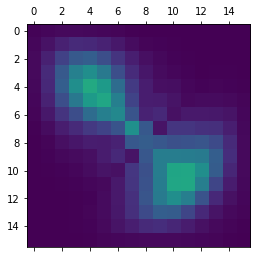

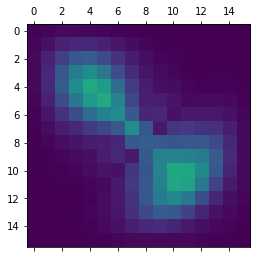

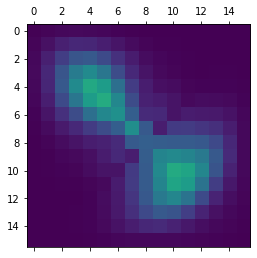

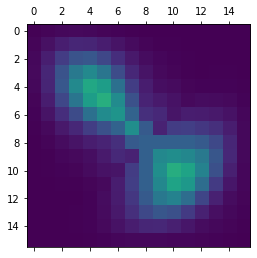

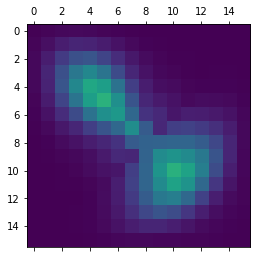

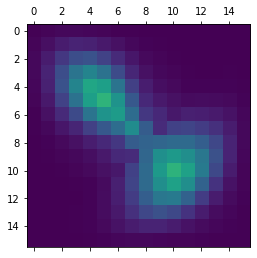

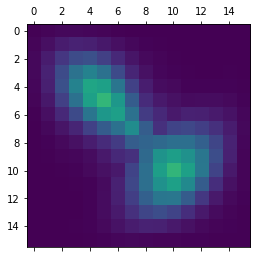

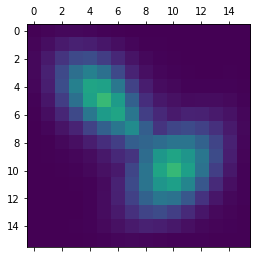

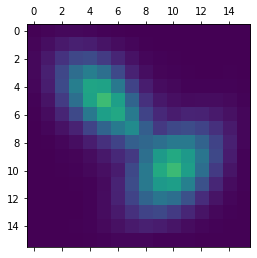

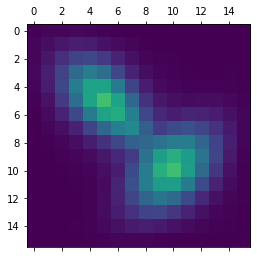

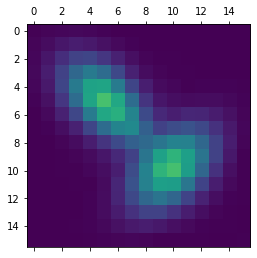

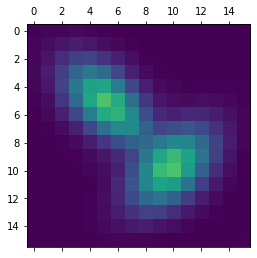

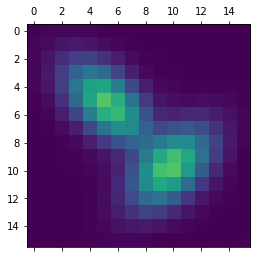

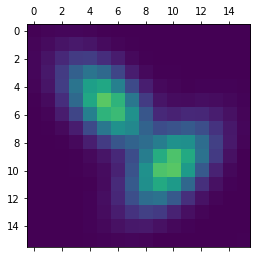

0.9172777183805366


In [7]:
p=mu_1
ls=[p.cpu().numpy()]
path_enr=0
path_enr=[]
fig, axes = plt.subplots(ncols=19, figsize=(190, 10))
axes[0].pcolormesh(grid[0,:,:,0].cpu(),grid[0,:,:,1].cpu(), p[0,0].transpose(0,1).cpu())
axes[0].set_xlim([-1, 1])
axes[0].set_ylim([-1, 1])
for i in range(1,vecs.shape[0]):
    X=vecs[i]
    path_enr += [InnerProd(X,mu_1,p,m).item()]
    def_grid=grid-X
    axes[2*i-1].pcolormesh(def_grid[0,:,:,0].cpu(), def_grid[0,:,:,1].cpu(), p[0,0].transpose(0,1).cpu())
    axes[2*i-1].set_xlim([-1, 1])
    axes[2*i-1].set_ylim([-1, 1])
    p=tnn.grid_sample(p,grid+X).transpose(2,3)
    p=p/p.sum()
    ls+=[p.cpu().numpy()]
    axes[2*i].pcolormesh(grid[0,:,:,0].cpu(),grid[0,:,:,1].cpu(), p[0,0].transpose(0,1).cpu())
    axes[2*i].set_xlim([-1, 1])
    axes[2*i].set_ylim([-1, 1])
plt.show()


ps= np.concatenate(ls,axis=0)
print(ps.shape)    

xp=np.linspace(0,1,N,endpoint=True)
x=np.linspace(0,1,120,endpoint=True)    
f=scipy.interpolate.interp1d(xp,ps,axis=0)
pss=f(x)


imgs = [Image.fromarray(np.floor(((255/vmax)*img[0]))) for img in pss]
imgs[0].save("array.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)
    
for i in range(0,pss.shape[0]):
    plt.matshow(pss[i,0], vmin=0, vmax=vmax)
    plt.show()
    
print(np.sqrt(np.array(path_enr)).sum()*(1/(N-1)))

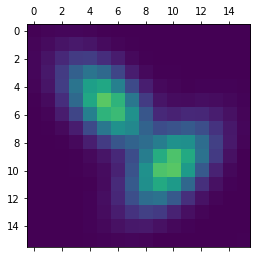

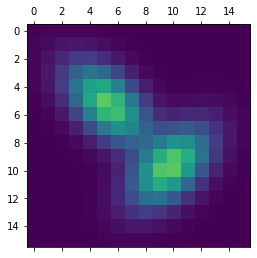

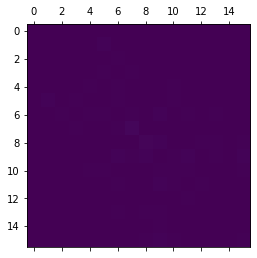

tensor(0.0009, dtype=torch.float64)


In [8]:
plt.matshow(p[0,0].cpu().numpy(), vmin=0, vmax=vmax)
plt.show()
plt.matshow(mu_2[0,0].cpu().numpy(), vmin=0, vmax=vmax)
plt.show()
plt.matshow(torch.abs(mu_2[0,0]-p[0,0]).cpu().numpy(), vmin=0, vmax=vmax)
plt.show()
print(L2Error(p,mu_2))